## Import dataset from website

In [23]:
# Text retrieval
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import string
import nltk
from nltk import word_tokenize, pos_tag, FreqDist
from nltk.corpus import stopwords

#LDA
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [2]:
# Get html code from url and store in r1
url1 = "https://www.gutenberg.org/files/27200/27200-h/27200-h.htm#jewish_m"
r1 = requests.get(url1)

# Get html code using BeautifulSoup for better readability
soup1 = BeautifulSoup(r1.content, 'html5lib')

In [3]:
# store all content within h3 and p tag as list "stories"
stories = soup1.find_all(["h3", "p"])
print(stories[0])
print(stories[-1])

# Extract the tag names (either h3 or p) and create a list
tag_names = [element.name for element in stories]

# Print the list of tag names
print(tag_names[0:5])

<h3 align="center">
A STORY
</h3>
<p>
"This is all very fine, no doubt," said the sparrows, "and it is
very beautiful; but it is not according to the calendar, therefore, it
must be all wrong."
</p>
['h3', 'p', 'p', 'p', 'p']


In [4]:
## Get dictionary of title and story text
story_list = []
story_dict = {}

for i, story in enumerate(stories):
    #check if story is title
    if tag_names[i] == 'h3':
        # append to story_list if story_dict not empty
        if story_dict != {}:  
            story_list.append(story_dict)
        #store text within is title as new row
        story_dict = {"title":story.get_text(strip=True), "story": ""} 
    else:
        #add text of is_paragraph to dict
        story_dict["story"] += story.get_text(strip=True)
        
# append last item to story_list
story_list.append(story_dict) 

In [5]:
# Replace "\n" with " "  and remove "\" in the 'story' values
for item in story_list:
    item["story"] = item["story"].replace("\n", " ")
    
print(f"Number of stories: {len(story_list)}")

Number of stories: 211


In [6]:
df_story = pd.DataFrame.from_dict(story_list)
df_story.head()

,title,story
0,A STORY,In the garden all the apple-trees were in blos...
1,BY THE ALMSHOUSE WINDOW,Near the grass-covered rampart which encircles...
2,THE ANGEL,"""Whenever a good child dies, an angel of God c..."
3,ANNE LISBETH,"Anne Lisbeth was a beautiful young woman, with..."
4,THE CONCEITED APPLE-BRANCH,It was the month of May. The wind still blew ...


## Text Preprocessing

In [12]:
##Use pos tagging + lemmatizing

mystopwords = stopwords.words("english") + ['come', 'go', 'say', 'see', 'look'] #from 1st LDA run
#instantiate lemmatizer
wnl = nltk.WordNetLemmatizer()

def lemmaNVAR(wpos):
    #input: tuple of (word token, pos)
    #output: lemmatized word token
    lemmas = []
    for w, pos in wpos:
        if pos[0] in ('N', 'V', 'J', 'R'):
            if pos in ('NNS', 'RBR', 'RBS', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'):
                lemmas.append(wnl.lemmatize(w, pos = pos[0].lower()))
            elif pos in ('JJR', 'JJS'):
                lemmas.append(wnl.lemmatize(w, pos = 'a'))
            else:
                lemmas.append(w)
    return lemmas

def get_lemmas(text):
    #input: raw text
    #output: preprocessed word token
    tokens = [word_tokenize(t.lower()) for t in text] # get list of tokens in lowercase
    tokens = [[w for w in t if w not in string.punctuation+"’“”"] for t in tokens] # remove punctuations
    tokens = [pos_tag(t) for t in tokens] # get POS
    tokens = [lemmaNVAR(t) for t in tokens] # lemmatize
    tokens = [[w for w in t if w not in mystopwords] for t in tokens] # remove stopwords
    return tokens


In [13]:
#run function for concatenated title and story

text = df_story["title"] + " " + df_story["story"]
t_lemma = get_lemmas(text)
print(len(t_lemma))
t_lemma[0][5:10]


211


['bring', 'forth', 'flower', 'get', 'green']

## Topic Modelling

In [14]:
# Use dictionary (built from corpus) to prepare a DTM (using frequency)

# Filter off any words with document frequency less than 2, or appearing in more than 90% documents
dictionary = corpora.Dictionary(t_lemma)
dictionary.filter_extremes(no_below=2, no_above=0.9)
print(dictionary)

Dictionary<5799 unique tokens: ["'s", 'able', 'adorn', 'ago', 'air']...>


In [15]:
# get dtm as list of list
dtm = [dictionary.doc2bow(d) for d in t_lemma]

In [27]:
# Compute Coherence Score for 3-20 topics
n_topics = list(range(3,21))
coherence_score = []

for i in n_topics:
    lda = gensim.models.ldamodel.LdaModel(dtm, num_topics = i, id2word = dictionary, chunksize=128, passes=10,random_state=10)
    coherence_model_lda = CoherenceModel(model=lda, texts=t_lemma, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

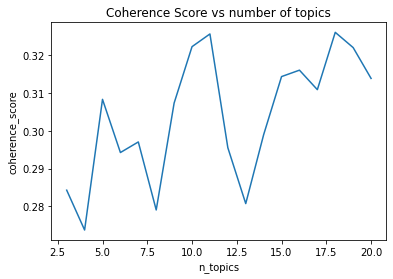

In [28]:
#plot coherence vs number of topics
sns.lineplot(x=n_topics, y=coherence_score)

# Add labels and a title
plt.xlabel('n_topics')
plt.ylabel('coherence_score')
plt.title('Coherence Score vs number of topics')

# Display the chart
plt.show()

In [29]:
lda_5 = gensim.models.ldamodel.LdaModel(dtm, num_topics = 5, id2word = dictionary, chunksize=128, passes=10,random_state=10)
lda_5.show_topics(10)

[(0,
  '0.021*"reindeer" + 0.016*"robber-girl" + 0.010*"gerda" + 0.009*"finland" + 0.008*"lapland" + 0.007*"rise" + 0.006*"grave" + 0.005*"buckwheat" + 0.004*"nightingale" + 0.003*"throne"'),
 (1,
  '0.011*"little" + 0.008*"old" + 0.008*"good" + 0.007*"know" + 0.006*"take" + 0.006*"think" + 0.006*"make" + 0.006*"great" + 0.005*"well" + 0.005*"quite"'),
 (2,
  '0.015*"rudy" + 0.012*"babette" + 0.010*"sausage" + 0.010*"skewer" + 0.010*"mouse" + 0.009*"soup" + 0.008*"miller" + 0.006*"make" + 0.005*"great" + 0.005*"know"'),
 (3,
  '0.015*"little" + 0.007*"old" + 0.006*"flower" + 0.005*"beautiful" + 0.005*"stand" + 0.005*"away" + 0.005*"fly" + 0.005*"tree" + 0.005*"wind" + 0.005*"know"'),
 (4,
  '0.015*"man" + 0.009*"old" + 0.006*"know" + 0.006*"great" + 0.005*"house" + 0.005*"away" + 0.005*"shadow" + 0.005*"time" + 0.005*"people" + 0.005*"think"')]

### 5 common topics in Andersen's story:
* 0: Winter Folklore stories - such as
* 1: Stories involving moral virtues
* 2: Stories with food-related elements
* 3: Stories involving beauty of nature
* 4: Stories involving people and society

## Assign Topics of Individual Stories

In [33]:
# Create dict of topics discovered
story_topics = {0: 'winter folklore', 1: 'moral virtues', 2: 'food-related', 3: 'nature', 4:'people and society'}

# Get the topic distribution of documents
doc_topics = lda_5.get_document_topics(dtm)

#show the topic distributions for the first 5 docs, 
for i in range(0, 5):
    print(doc_topics[i])
    print(max(doc_topics[i], key=itemgetter(1))[0]) 

[(0, 0.041108944), (1, 0.5671115), (3, 0.34305522), (4, 0.048425816)]
1
[(1, 0.3067212), (3, 0.68914247)]
3
[(1, 0.35726494), (3, 0.6412218)]
3
[(1, 0.31044924), (3, 0.46060026), (4, 0.22870636)]
3
[(1, 0.55503994), (3, 0.44005224)]
1


In [34]:
#Select the best topic (with highest score) for each document
top_topic = [ max(t, key=itemgetter(1))[0] for t in doc_topics ]
print(top_topic)

[1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 4, 3, 1, 4, 3, 1, 1, 1, 3, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 4, 1, 4, 1, 3, 1, 3, 1, 1, 1, 4, 1, 3, 4, 4, 4, 4, 4, 2, 3, 3, 4, 2, 4, 3, 2, 4, 3, 4, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 4, 3, 1, 3, 4, 3, 3, 3, 3, 3, 4, 4, 1, 1, 3, 4, 1, 3, 4, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 4, 1, 4, 2, 4, 4, 1, 4, 4, 1, 1, 3, 1, 1, 1, 1, 1, 4, 4, 1, 4, 4, 3, 1, 1, 1, 3, 1, 1, 1, 1, 4, 4, 1, 1, 1, 3, 1, 3, 1, 4, 1, 1, 4, 4, 3, 4, 1, 0, 3, 2, 3, 2, 1, 4, 3, 0, 3, 4, 3, 3, 1, 2, 2, 1, 2, 2, 1, 4, 3, 3, 3, 1, 1, 4, 4, 3, 1, 1, 1, 1, 1, 4, 1, 4, 3, 1, 3, 3, 4, 3, 1, 3]


In [35]:
# Add top_topic as column in df_story
df_story["top_topic"] = top_topic
df_story["top_topic"] = df_story["top_topic"].replace(story_topics)
df_story.tail()

,title,story,top_topic
206,THE WILD SWANS,Far away in the land to which the swallows fly...,nature
207,"THE WILL-O-THE WISP IS IN THE TOWN, SAYS THE M...","There was a man who once knew many stories, bu...",people and society
208,THE STORY OF THE WIND,"""Near the shores of the great Belt, which is o...",nature
209,THE WINDMILL,"A windmill stood upon the hill, proud to look ...",moral virtues
210,THE STORY OF THE YEAR,"It was near the end of January, and a terrible...",nature


In [36]:
df_story.to_excel("andersen_story_topics.xlsx", index = False)